In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel
from torchts.nn.models.seq2seq import Encoder, Decoder, Seq2Seq 

# Generate dataset

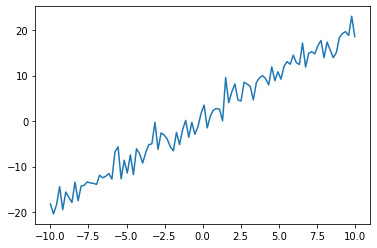

In [2]:
# generate linear time series data with some noise
x = np.linspace(-10,10,100).reshape(-1,1).astype(np.float32)
y = 2*x+1 + np.random.normal(0, 2, x.shape).reshape(-1,1).astype(np.float32)
plt.plot(x.flatten(), y.flatten())
plt.show()

In [3]:
x = x[..., np.newaxis]
y = y[..., np.newaxis]

# Build a LSTM model

In [3]:
class LSTM(TimeSeriesModel):
    def __init__(self, input_size, output_size, optimizer, hidden_size=8, batch_size=10, **kwargs):
        super(LSTM, self).__init__(optimizer, **kwargs)
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.lstm = torch.nn.LSTMCell(input_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        # initialize the hidden state and the cell state to zeros
        return (torch.zeros(self.batch_size, self.hidden_size),
                torch.zeros(self.batch_size, self.hidden_size))

    def forward(self, x, y=None, batches_seen=None):
        hc = self.init_hidden()
        
        hidden, _ = self.lstm(x, hc)
        out = self.linear(hidden)
        return out

# Seq2Seq

In [4]:
# define hyper-parameters
dropout_rate = 0.8
num_layers = 1
hidden_dim = 32
input_dim = 1
output_dim = 1
horizon = 20
batch_size = 64

# uncertainty quantification
quantiles = [0.025, 0.5, 0.975]

In [7]:
# instantiate seq2seq model
models = {}
for quantile in quantiles:
    encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
    decoder = Decoder(output_dim, hidden_dim, num_layers, dropout_rate)

    models[quantile] = Seq2Seq(
        encoder, 
        decoder, 
        output_dim, 
        horizon,
        optimizer=torch.optim.Adam,
        criterion=quantile_loss,
        criterion_args={"quantile": quantile}
    )

In [8]:
# train model
for _, model in models.items():
    model.fit(
        torch.from_numpy(x),
        torch.from_numpy(y),
        max_epochs=300,
        batch_size=batch_size,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 9.0 K 
1 | decoder | Decoder | 17.2 K
------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 61.86it/s, loss=4.71, v_num=97, train_loss_step=4.350, train_loss_epoch=4.700]

/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 299: 100%|██████████| 2/2 [00:00<00:00, 25.24it/s, loss=0.287, v_num=97, train_loss_step=0.283, train_loss_epoch=0.283]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 9.0 K 
1 | decoder | Decoder | 17.2 K
------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105     Total estimated model params size (MB)


Epoch 299: 100%|██████████| 2/2 [00:00<00:00, 47.49it/s, loss=0.776, v_num=98, train_loss_step=0.789, train_loss_epoch=0.752]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 9.0 K 
1 | decoder | Decoder | 17.2 K
------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105     Total estimated model params size (MB)


Epoch 299: 100%|██████████| 2/2 [00:00<00:00, 33.09it/s, loss=0.289, v_num=99, train_loss_step=0.245, train_loss_epoch=0.295]


In [12]:
models[0.025](torch.from_numpy(x))

torch.Size([100, 20, 1])

In [13]:
# inference
y_preds = {}
for q, model in models.items():
    y_preds[q] = model(torch.from_numpy(x)).detach().numpy()

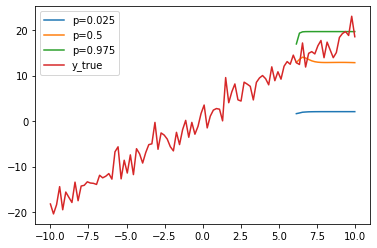

In [14]:
plt.plot(x[-horizon:].flatten(), y_preds[0.025][-horizon].flatten(), label="p=0.025")
plt.plot(x[-horizon:].flatten(), y_preds[0.5][-horizon].flatten(), label="p=0.5")
plt.plot(x[-horizon:].flatten(), y_preds[0.975][-horizon].flatten(), label="p=0.975")
plt.plot(x.flatten(), y.flatten(), label="y_true")
plt.legend()
plt.show()

# Enable uncertainty quantification in LSTM model

In [6]:
import torch

from torchts.nn.loss import quantile_loss

In [9]:
inputDim = 1       
outputDim = 1 
optimizer_args = {"lr": 0.01}
quantiles = [0.025, 0.5, 0.975]

batch_size = 10
models = {quantile: LSTM(
    inputDim, 
    outputDim, 
    torch.optim.Adam,
    criterion=quantile_loss, 
    criterion_args={"quantile": quantile}, 
    optimizer_args=optimizer_args
    ) for quantile in quantiles}

In [10]:
for _, model in models.items():
    # train model
    model.fit(
        torch.from_numpy(x),
        torch.from_numpy(y),
        max_epochs=100,
        batch_size=batch_size,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 9     
------------------------------------
361       Trainable params
0         Non-trainable params
361       Total params
0.001     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/10 [00:00<00:00, 459.70it/s]  

/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 172.89it/s, loss=0.123, v_num=87, train_loss_step=0.181, train_loss_epoch=0.124]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 9     
------------------------------------
361       Trainable params
0         Non-trainable params
361       Total params
0.001     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 92.43it/s, loss=0.811, v_num=88, train_loss_step=0.886, train_loss_epoch=0.801] 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 9     
------------------------------------
361       Trainable params
0         Non-trainable params
361       Total params
0.001     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 124.69it/s, loss=0.126, v_num=89, train_loss_step=0.123, train_loss_epoch=0.129]


In [14]:
# inference
y_preds = {}
for x_batch in torch.split(torch.from_numpy(x), batch_size):
    for q, model in models.items():
        if q not in y_preds:
            y_preds[q] = [model.predict(x_batch).detach().numpy()]
        else:
            y_preds[q].append(model.predict(x_batch).detach().numpy())
y_preds = {q: np.concatenate(y_pred) for q, y_pred in y_preds.items()}

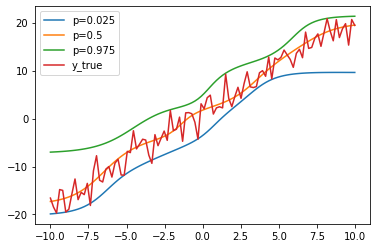

In [15]:
plt.plot(x.flatten(), y_preds[0.025].flatten(), label="p=0.025")
plt.plot(x.flatten(), y_preds[0.5].flatten(), label="p=0.5")
plt.plot(x.flatten(), y_preds[0.975].flatten(), label="p=0.975")
plt.plot(x.flatten(), y.flatten(), label="y_true")
plt.legend()
plt.show()